## Linear least-squares and a bland dense network

We're going to use the MIT-BIH datasets to train and test a basic feedforward network and see how it does. We'll compare the results to a linear regression.

We'll use two different inputs: a mostly unprocessed version of the dataset, and a version in the frequency domain obtained by applying the FFT.

In [1]:
import datetime
import os
import logging
import numpy as np
import tensorflow as tf

import tools.plotdata as pltdat
import tools.train as train

## Read in data
files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
inputs, labels, sparse_labels, df = train.preprocess(*files, fft=False)
inputs_fft = train.dataset_fft(inputs)
train.class_count(df)


Train set
Count of each class
Classes
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
dtype: int64

Test set
Count of each class
Classes
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
dtype: int64


Let's look at a few random samples of the training data:

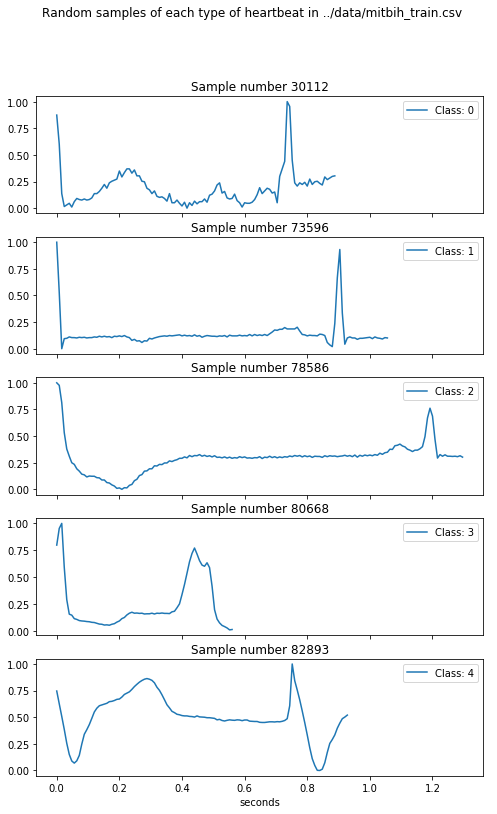

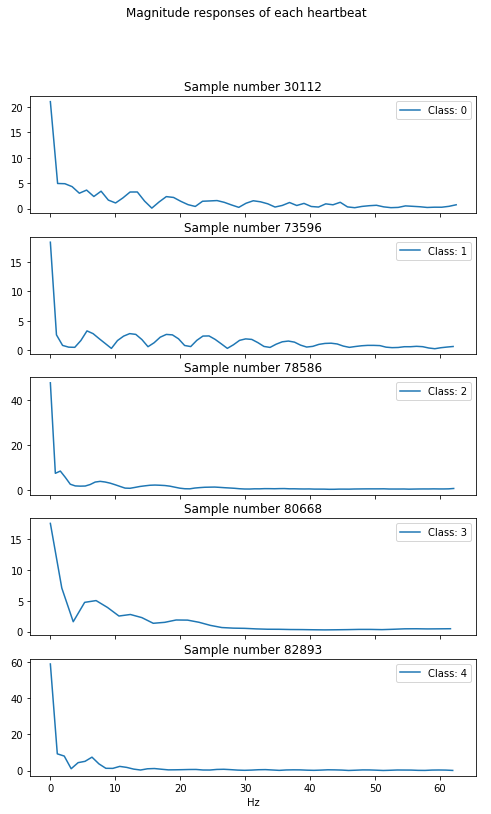

In [2]:
pltdat.plot_ecg(files[0], 125, 1)

### Least-squares
Let's try least-squares regression with numpy.

In [3]:
lstsq_soln = np.linalg.lstsq(inputs["train"], labels["train"], rcond=None)
lstsq_soln_fft = np.linalg.lstsq(inputs_fft["train"], labels["train"], rcond=None)
print("Rank of training dataset:", lstsq_soln[2])
print("Rank of training dataset after (real) FFT:", lstsq_soln_fft[2])

Rank of training dataset: 187
Rank of training dataset after (real) FFT: 94


Now let's see how accurate it is.

Regular least-squares
Training accuracy: 0.8948306188181008
Test accuracy: 0.8952128631463548


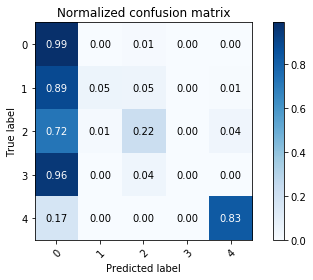

In [4]:
def lstsq_accuracy(inputs, labels, coeffs):
    
    predict = {}
    accuracy = {}
    for key in inputs:
        predict[key] = np.argmax(np.dot(inputs[key], coeffs), axis=1)
        num_correct = np.sum(
            labels[key][range(labels[key].shape[0]), predict[key]] == 1
        )
        accuracy[key] = num_correct / labels[key].shape[0]
    print("Training accuracy:", accuracy["train"])
    print("Test accuracy:", accuracy["test"])
    
    return predict

print("Regular least-squares")
predict = lstsq_accuracy(inputs, labels, lstsq_soln[0])
train.plot_cm(sparse_labels["test"], predict["test"], classes=np.arange(5), normalize=True)

After FFT
Training accuracy: 0.9001073623135436
Test accuracy: 0.8965375479627261


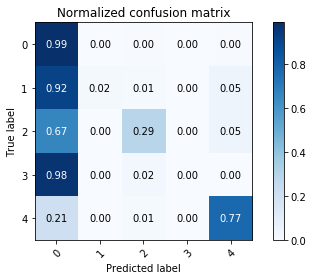

In [5]:
print("After FFT")
predict_fft = lstsq_accuracy(inputs_fft, labels, lstsq_soln_fft[0])
train.plot_cm(sparse_labels["test"], predict_fft["test"], classes=np.arange(5), normalize=True)

### Dense feed-forward network
Let's try an unregularized, bland feed-forward network with a couple of hidden layers.

Unprocessed data
Model: "dense_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187)]             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 940       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
Total params: 1,000
Trainable params: 1,000
Non-trainable params: 0
_________________________________________________________________

Training
Train acc: 0.9478379
Test acc: 0.9455966


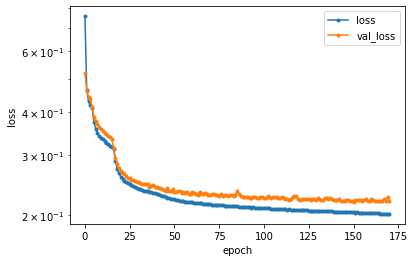

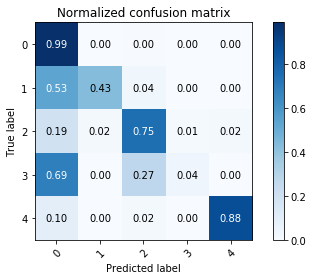

In [6]:
# Tensorboard logging
rightnow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
nofftpath = os.path.join("..", "logs", rightnow, "nofft")

config = {"optimizer": "Nadam",
          "loss": "categorical_crossentropy",
          "batch_size": 200,
          "val_split": 0.05,
          "epochs": 300,
          "verbose": 0,
          "patience": 20,
          "logdir": nofftpath}
hiddenlayers = [(5, "relu"), (5, "relu")]

# Suppress tensorflow warnings about internal deprecations
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print("Unprocessed data")
history, model = train.train_dense(inputs, labels, hiddenlayers, config)
train.plot_fit_history(history)

test_pred = np.argmax(model.predict(inputs["test"]), axis=1)
train.plot_cm(sparse_labels["test"], test_pred, classes=np.arange(5), normalize=True)

After FFT
Model: "dense_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 94)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 475       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 30        
Total params: 535
Trainable params: 535
Non-trainable params: 0
_________________________________________________________________

Training
Train acc: 0.9284213
Test acc: 0.92490405


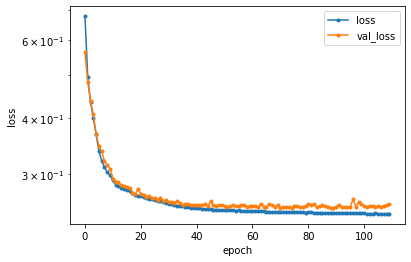

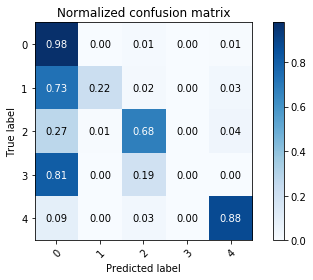

In [7]:
# Tensorboard logging
fftpath = os.path.join("..", "logs", rightnow, "fft")
config_fft = config
config_fft["logdir"] = fftpath

print("After FFT")
history_fft, model_fft = train.train_dense(inputs_fft, labels, hiddenlayers, config_fft)
train.plot_fit_history(history_fft)

test_pred_fft = np.argmax(model_fft.predict(inputs_fft["test"]), axis=1)
train.plot_cm(sparse_labels["test"], test_pred_fft, classes=np.arange(5), normalize=True)

The results don't tend to be very consistent. The final test accuracy varies from run to run generally fairly significantly and it's not clear if the FFT "does" anything for the accuracy of the training.